In [1]:
#==========================================================================
# Import Libraries
#==========================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../Source")
from Posteriors import Posterior

In [15]:
#==========================================================================
# Define: Explicit form of Likelihood, DFD, KSD for Bernoullie Model
#==========================================================================

def neg_loglikel(p, X):
    return - ( X * p.log() + (1 - X) * (1 - p).log() ).mean()

def dfd(p, X):
    c1 = ( p ** (1 - X) ) * ( (1 - p) ** X )
    c2 = ( p ** X ) * ( (1 - p) ** (1 - X) )
    rm = c1 / c2
    rp = c2 / c1
    return ( rm ** 2.0 - 2.0 * rp ).mean()
    
def ksd(p, X):
    c1 = ( p ** (1 - X) ) * ( (1 - p) ** X )
    c2 = ( p ** X ) * ( (1 - p) ** (1 - X) )
    rm = ( 1.0 - c1 / c2 ).reshape(-1,1)
    XV = X.reshape(-1,1)
    KX = 1 - torch.cdist(XV, XV, p=0)
    KXD = ( ( 1 - torch.cdist(1-XV, XV, p=0) ) - KX ).mean(axis=1)
    return ( rm @ rm.t() * KX ).mean() + 2.0 * ( rm.flatten() * KXD ).mean()


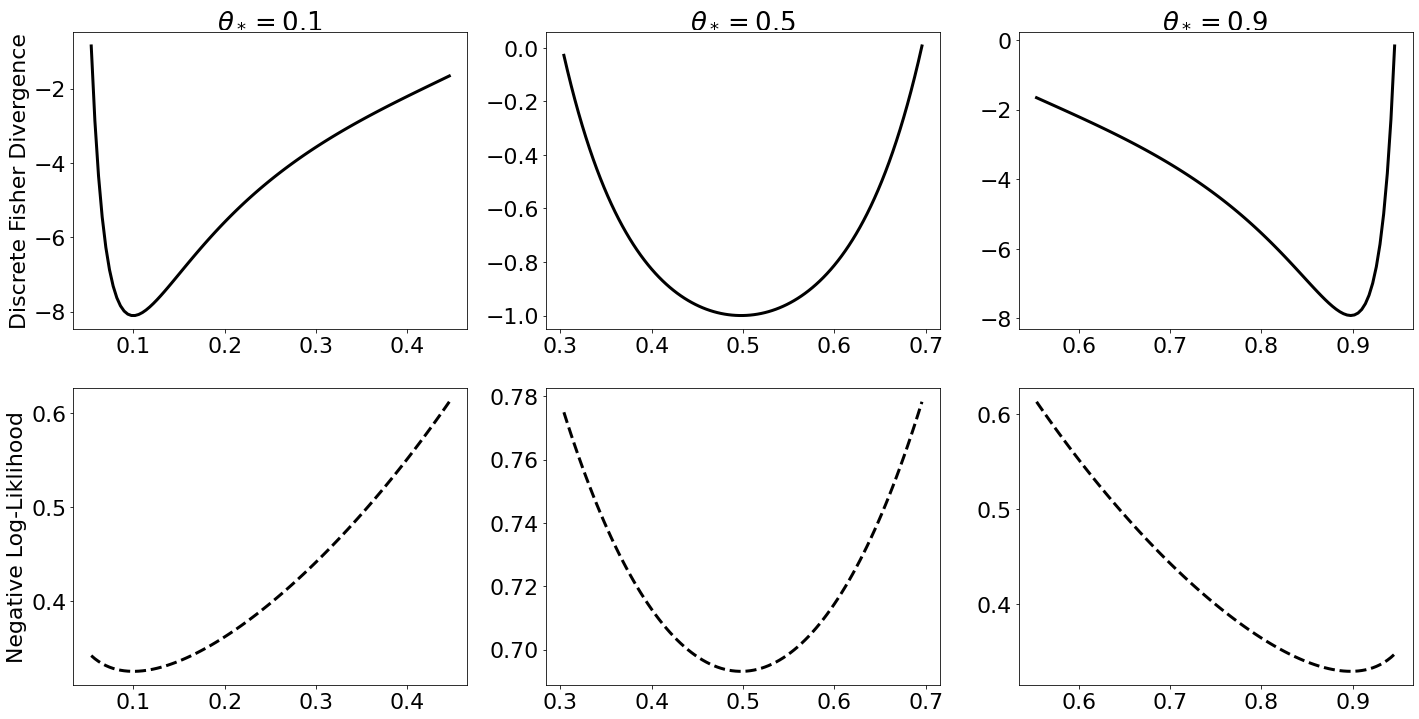

In [16]:
#==========================================================================
# Plot loss surfaces for a given Bernoullie parameter p
#==========================================================================

def experiment(p=0.5, N=100, xmin=0.0, xmax=1.0, plotaxs=None):
    torch.manual_seed(0)
    
    DGP = torch.distributions.Bernoulli(p)
    X = DGP.sample(sample_shape=(N,1))
    
    P = torch.linspace(xmin, xmax, 101)[1:-1]
    DFD = torch.tensor([ dfd(p, X) for p in P ])
    NLL = torch.tensor([ neg_loglikel(p, X) for p in P ])
    #KSD = torch.tensor([ ksd(p, X) for p in P ])
    
    sns.lineplot(x=P, y=DFD, linewidth=3.0, color="black", linestyle="-", ax=plotaxs[0])
    sns.lineplot(x=P, y=NLL, linewidth=3.0, color="black", linestyle="--", ax=plotaxs[1])
    #sns.lineplot(x=P, y=KSD, ax=plotaxs[2])

fig, axs = plt.subplots(2, 3, figsize=(24,12))
experiment(p=0.10, N=500, xmin=0.05, xmax=0.45, plotaxs=axs[:,0])
experiment(p=0.50, N=500, xmin=0.30, xmax=0.70, plotaxs=axs[:,1])
experiment(p=0.90, N=500, xmin=0.55, xmax=0.95, plotaxs=axs[:,2])
for i in range(2):
    for j in range(3):
        axs[i,j].tick_params(axis='x', labelsize=22)
        axs[i,j].tick_params(axis='y', labelsize=22)
axs[0,0].set_ylabel("Discrete Fisher Divergence", fontsize=22)
axs[1,0].set_ylabel("Negative Log-Liklihood", fontsize=22)
axs[0,0].set_title(r"$\theta_* = 0.1$", fontsize=26)
axs[0,1].set_title(r"$\theta_* = 0.5$", fontsize=26)
axs[0,2].set_title(r"$\theta_* = 0.9$", fontsize=26)
fig.savefig('figure_13.eps', format='eps')


100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 321.91it/s]


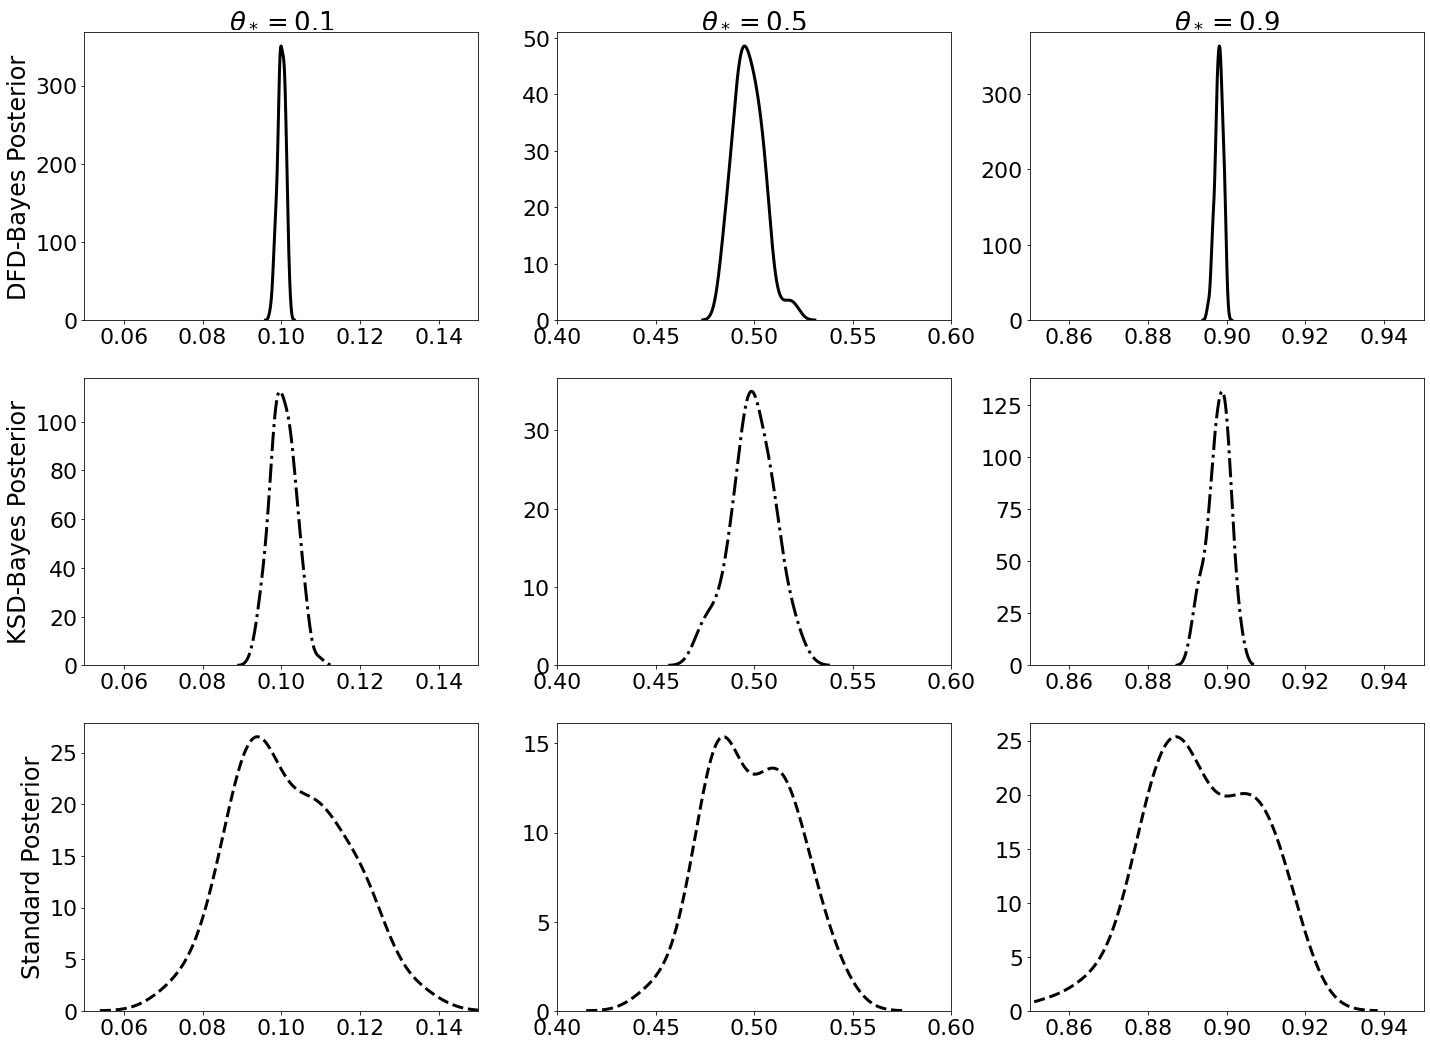

In [17]:
#==========================================================================
# Define: Posterior
#==========================================================================

def experiment(p=0.5, N=100, xmin=0.0, xmax=1.0, plotaxs=None):
    torch.manual_seed(0)
    
    DGP = torch.distributions.Bernoulli(p)
    X = DGP.sample(sample_shape=(N,1))
    
    prior = torch.distributions.Beta(torch.tensor([2.0]), torch.tensor([2.0]))
    log_prior = lambda param: prior.log_prob(param).sum()
    transit_p = torch.distributions.Normal(torch.zeros(1), 0.01*torch.ones(1))
    
    nll_bayes = Posterior(log_prior)
    dfd_bayes = Posterior(log_prior)
    ksd_bayes = Posterior(log_prior)
    nll_bayes.loss = lambda param: X.shape[0] * neg_loglikel(param, X)
    dfd_bayes.loss = lambda param: X.shape[0] * dfd(param, X)
    ksd_bayes.loss = lambda param: X.shape[0] * ksd(param, X)
    
    nll_sample = nll_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20)
    dfd_sample = dfd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20)
    ksd_sample = ksd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20)
    
    sns.kdeplot(dfd_sample.flatten(), linewidth=3.0, color="black", linestyle="-", bw_method="silverman", ax=plotaxs[0])
    sns.kdeplot(ksd_sample.flatten(), linewidth=3.0, color="black", linestyle="-.", bw_method="silverman", ax=plotaxs[1])
    sns.kdeplot(nll_sample.flatten(), linewidth=3.0, color="black", linestyle="--", bw_method="silverman", ax=plotaxs[2])

    plotaxs[0].set_xlim(xmin, xmax)
    plotaxs[1].set_xlim(xmin, xmax)
    plotaxs[2].set_xlim(xmin, xmax)

    
fig, axs = plt.subplots(3, 3, figsize=(24,18))
experiment(p=0.10, N=500, xmin=0.05, xmax=0.15, plotaxs=axs[:,0])
experiment(p=0.50, N=500, xmin=0.40, xmax=0.60, plotaxs=axs[:,1])
experiment(p=0.90, N=500, xmin=0.85, xmax=0.95, plotaxs=axs[:,2])
for i in range(3):
    for j in range(3):
        axs[i,j].set_ylabel("")
        axs[i,j].tick_params(axis='x', labelsize=22)
        axs[i,j].tick_params(axis='y', labelsize=22)
axs[0,0].set_ylabel("DFD-Bayes Posterior", fontsize=24)
axs[1,0].set_ylabel("KSD-Bayes Posterior", fontsize=24)
axs[2,0].set_ylabel("Standard Posterior", fontsize=24)
axs[0,0].set_title(r"$\theta_* = 0.1$", fontsize=26)
axs[0,1].set_title(r"$\theta_* = 0.5$", fontsize=26)
axs[0,2].set_title(r"$\theta_* = 0.9$", fontsize=26)
fig.savefig('figure_14.eps', format='eps')



Final Loss: -4253.08594: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.34it/s]


tensor(0.0021)


Final Loss: -633.41370: 100%|██████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


tensor(0.0282)


Final Loss: -498.62396: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.66it/s]


tensor(0.1076)


Final Loss: -0.23996: 100%|████████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


tensor(0.2660)


Final Loss: -4907.52148: 100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 24.85it/s]


tensor(0.0026)


Final Loss: -597.30847: 100%|██████████████████████████████████████████| 100/100 [00:19<00:00,  5.13it/s]


tensor(0.0256)


100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 344.88it/s]


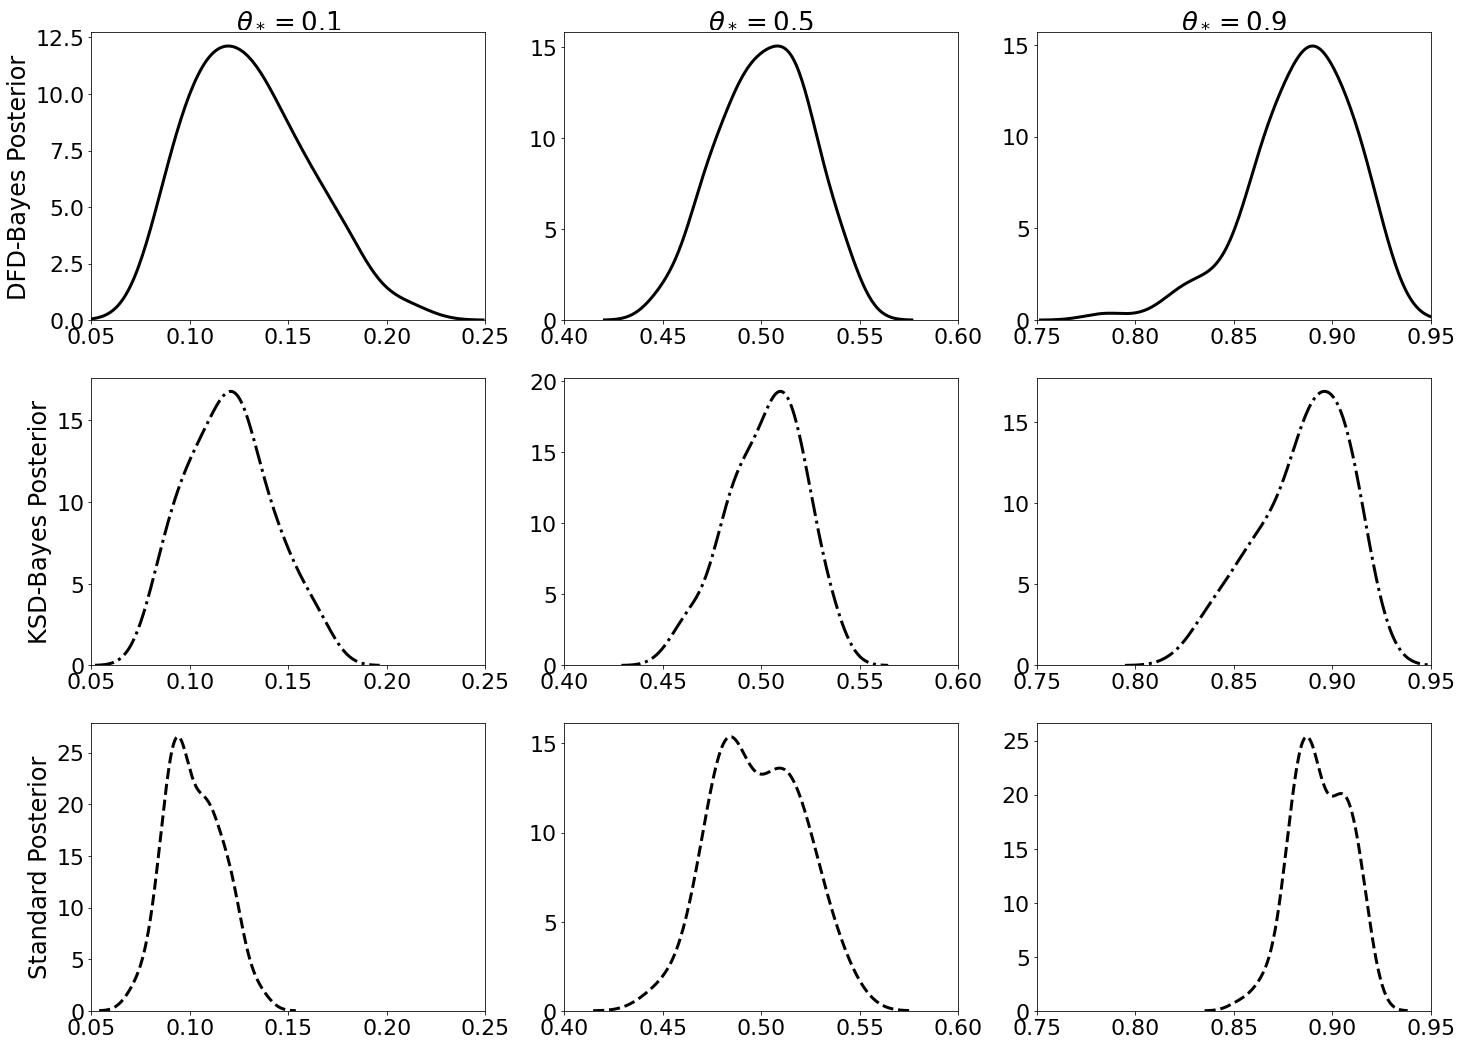

In [18]:
#==========================================================================
# Define: Posterior
#==========================================================================

def experiment(p=0.5, N=100, xmin=0.0, xmax=1.0, plotaxs=None):
    torch.manual_seed(0)
    
    DGP = torch.distributions.Bernoulli(p)
    X = DGP.sample(sample_shape=(N,1))
    
    prior = torch.distributions.Beta(torch.tensor([2.0]), torch.tensor([2.0]))
    log_prior = lambda param: prior.log_prob(param).sum()
    transit_p = torch.distributions.Normal(torch.zeros(1), 0.01*torch.ones(1))
    
    nll_bayes = Posterior(log_prior)
    dfd_bayes = Posterior(log_prior)
    ksd_bayes = Posterior(log_prior)
    dfd_loss = lambda param: X.shape[0] * dfd(param, X)
    dfd_loss_X = lambda param, X: X.shape[0] * dfd(param, X)
    ksd_loss = lambda param: X.shape[0] * ksd(param, X)
    ksd_loss_X = lambda param, X: X.shape[0] * ksd(param, X)
    
    nll_bayes.loss = lambda param: X.shape[0] * neg_loglikel(param, X)
    nll_sample = nll_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20)

    p_init, _ = dfd_bayes.minimise(dfd_loss, prior.sample(), ite=1000, lr=0.01, progress=False)
    boot_minimisers, _ = dfd_bayes.bootstrap_minimisers(X, 100, lambda: p_init, loss_func=dfd_loss_X, ite=100, lr=0.01)
    beta_opt = dfd_bayes.optimal_beta(dfd_loss, boot_minimisers)
    print(beta_opt)
    dfd_bayes.loss = dfd_loss
    dfd_sample = dfd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20, beta=beta_opt)

    p_init, _ = ksd_bayes.minimise(ksd_loss, prior.sample(), ite=1000, lr=0.01, progress=False)
    boot_minimisers, _ = ksd_bayes.bootstrap_minimisers(X, 100, lambda: p_init, loss_func=ksd_loss_X, ite=100, lr=0.01)
    beta_opt = ksd_bayes.optimal_beta(ksd_loss, boot_minimisers)
    print(beta_opt)
    ksd_bayes.loss = ksd_loss
    ksd_sample = ksd_bayes.sample(2000, 2000, transit_p, prior.sample(), domain="all", thin=20, beta=beta_opt)
    
    sns.kdeplot(dfd_sample.flatten(), linewidth=3.0, color="black", linestyle="-", bw_method="silverman", ax=plotaxs[0])
    sns.kdeplot(ksd_sample.flatten(), linewidth=3.0, color="black", linestyle="-.", bw_method="silverman", ax=plotaxs[1])
    sns.kdeplot(nll_sample.flatten(), linewidth=3.0, color="black", linestyle="--", bw_method="silverman", ax=plotaxs[2])
    
    plotaxs[0].set_xlim(xmin, xmax)
    plotaxs[1].set_xlim(xmin, xmax)
    plotaxs[2].set_xlim(xmin, xmax)

    
fig, axs = plt.subplots(3, 3, figsize=(24,18))
experiment(p=0.10, N=500, xmin=0.05, xmax=0.25, plotaxs=axs[:,0])
experiment(p=0.50, N=500, xmin=0.40, xmax=0.60, plotaxs=axs[:,1])
experiment(p=0.90, N=500, xmin=0.75, xmax=0.95, plotaxs=axs[:,2])
for i in range(3):
    for j in range(3):
        axs[i,j].set_ylabel("")
        axs[i,j].tick_params(axis='x', labelsize=22)
        axs[i,j].tick_params(axis='y', labelsize=22)
axs[0,0].set_ylabel("DFD-Bayes Posterior", fontsize=24)
axs[1,0].set_ylabel("KSD-Bayes Posterior", fontsize=24)
axs[2,0].set_ylabel("Standard Posterior", fontsize=24)
axs[0,0].set_title(r"$\theta_* = 0.1$", fontsize=26)
axs[0,1].set_title(r"$\theta_* = 0.5$", fontsize=26)
axs[0,2].set_title(r"$\theta_* = 0.9$", fontsize=26)
fig.savefig('figure_15.eps', format='eps')

